**GET THE DATA AND START EXPLORING IT, LET'S IMPORT ALL LIBS**

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests # library to handle requests

#from bs4 import BeautifulSoup
import os

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns

print('Libraries imported.')

Libraries imported.


In [3]:
# Define Foursquare Credentials and Version

CLIENT_ID = 'FDBCBD5N2ASDECRD1GSZWEHJTIYZACTJYFO1QKM1OJT45V3T' # your Foursquare ID
CLIENT_SECRET = 'HVWE5RJLCLTSCZSJQ5IRAZ5R1D2V1WI4FBI1BQ3N5VA2BSAM' # your Foursquare Secret
VERSION = '20201210' # Foursquare API version

**NOW LET'S DEFINE THE FUNCS WE ARE GOING TO USE LATER.**

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude


def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

**NOW LET'S USE THE ABOVE CODES TO GET OUR INITIAL NYC DATA**

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:
ny_data.shape

(306, 4)

There are 306 differetns neighborhoods in NY.

**INITIAL DATA ANALYSIS**

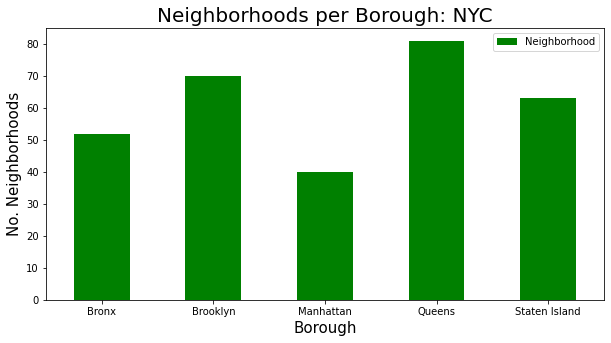

In [7]:
clr = "green"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

**LET'S ANALYZE FURTHER AND SEE HOW MANY SPANISH RESTAURANTS THERE ARE IN NY**

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains spanish restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
spanish_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    spanish_restaurants=venues[venues['Category']=='Spanish Restaurant']   
    print('(',count,'/',len(ny_data),')','Spanish Restaurants in '+Neighborhood+', '+Borough+':'+str(len(spanish_restaurants)))
    print(row)
    for resturant_detail in spanish_restaurants.values.tolist():
        id, name , category=resturant_detail
        spanish_rest_ny = spanish_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

sh Restaurants in Fordham, Bronx:2
['Bronx', 'Fordham', 40.86099679638654, -73.89642655981623]
( 18 / 306 ) Spanish Restaurants in East Tremont, Bronx:0
['Bronx', 'East Tremont', 40.84269615786053, -73.88735617532338]
( 19 / 306 ) Spanish Restaurants in West Farms, Bronx:0
['Bronx', 'West Farms', 40.83947505672653, -73.87774474910545]
( 20 / 306 ) Spanish Restaurants in High  Bridge, Bronx:0
['Bronx', 'High  Bridge', 40.836623010706056, -73.9261020935813]
( 21 / 306 ) Spanish Restaurants in Melrose, Bronx:0
['Bronx', 'Melrose', 40.819754370594936, -73.90942160757436]
( 22 / 306 ) Spanish Restaurants in Mott Haven, Bronx:1
['Bronx', 'Mott Haven', 40.80623874935177, -73.91609987487575]
( 23 / 306 ) Spanish Restaurants in Port Morris, Bronx:0
['Bronx', 'Port Morris', 40.801663627756206, -73.91322139386135]
( 24 / 306 ) Spanish Restaurants in Longwood, Bronx:0
['Bronx', 'Longwood', 40.81509904545822, -73.8957882009446]
( 25 / 306 ) Spanish Restaurants in Hunts Point, Bronx:1
['Bronx', 'Hun

KeyError: 'groups'

In [ ]:
#spanish_rest_ny.to_csv('spanish_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare
spanish_rest_ny.to_csv('spanish_rest_ny_tocsv1.csv')

In [10]:
spanish_ny = pd.read_csv('spanish_rest_ny_tocsv1.csv')
spanish_rest_ny.tail()

,Borough,Neighborhood,ID,Name
25,Queens,Jackson Heights,4d1a631e1683a1437bf37351,La Picada Azuaya
26,Queens,Jackson Heights,57b0b4dd498e4bc4715a9bb1,Barriles Restaurant and Sports bar
27,Queens,Richmond Hill,4ec1a837722e0f78de974903,Girasol Bakery
28,Queens,Ozone Park,4c39e32e18e72d7f32dc1af5,Libertad Restaurant
29,Queens,Bayside,5669ffe7498edbe082db916f,Sangarita's Tapas Wine


In [11]:
spanish_rest_ny.shape

(30, 4)

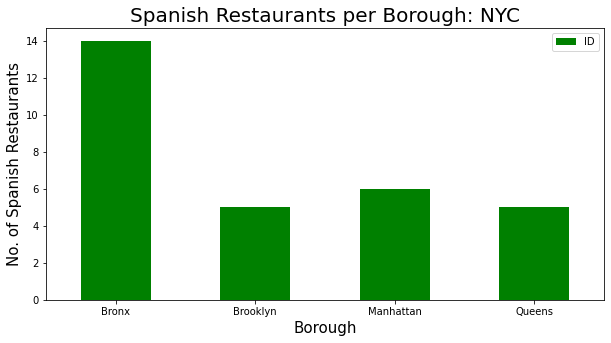

In [12]:
spanish_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Spanish Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Spanish Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

We got 30 Spanish Restaurants across the New York City.

As we continue our analysis, we see below that Bronx have the highest number of Spanish restaurants. Additionally, we see how many restaurants the top 6 neighborhoods have.


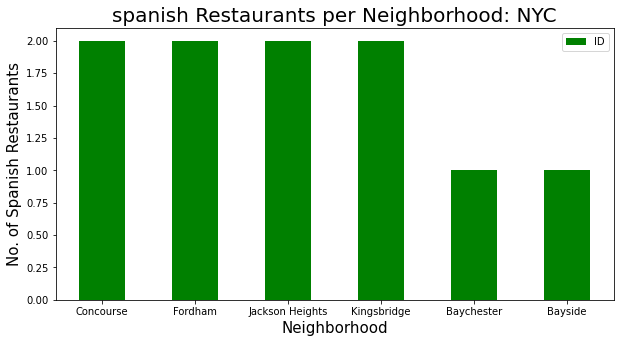

In [17]:
NOofNeigh = 6 # top number for graphing all the same past 6
spanish_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('spanish Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Spanish Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [18]:
spanish_rest_ny[spanish_rest_ny['Neighborhood']=='Concourse']


,Borough,Neighborhood,ID,Name
12,Bronx,Concourse,531285f5498e27c059004eee,El Gran Valle Restaurant
13,Bronx,Concourse,4c6dac3b10faa1439797ee68,Caridad Kitchen


In [19]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
spanish_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in spanish_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(spanish_rest_ny),')','processed')
    spanish_rest_stats_ny = spanish_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
spanish_rest_stats_ny.tail()

label': 'entrance', 'lat': 40.74981, 'lng': -73.882725}], 'postalCode': '11372', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['New York, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/barriles-restaurant-and-sports-bar/57b0b4dd498e4bc4715a9bb1', 'categories': [{'id': '4bf58dd8d48988d150941735', 'name': 'Spanish Restaurant', 'pluralName': 'Spanish Restaurants', 'shortName': 'Spanish', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/spanish_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 1}, 'price': {'tier': 2, 'message': 'Moderate', 'currency': '$'}, 'likes': {'count': 8, 'groups': [{'type': 'others', 'count': 8, 'items': [{'isSanctioned': False, 'firstName': 'Lewis', 'lastName': 'S', 'countryCode': 'US'}, {'isSanctioned': False, 'firstName': 'Philip', 'lastName': 'R', 'countryCode': 'US'}, {'isSanctioned': False, 'firstName': 'Juan', 'lastName': 'M', 'countryCo

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
25,Queens,Jackson Heights,4d1a631e1683a1437bf37351,La Picada Azuaya,6,7.9,2
26,Queens,Jackson Heights,57b0b4dd498e4bc4715a9bb1,Barriles Restaurant and Sports bar,8,7.3,1
27,Queens,Richmond Hill,4ec1a837722e0f78de974903,Girasol Bakery,2,5.7,8
28,Queens,Ozone Park,4c39e32e18e72d7f32dc1af5,Libertad Restaurant,6,6.7,5
29,Queens,Bayside,5669ffe7498edbe082db916f,Sangarita's Tapas Wine,12,7.9,0


In [20]:
spanish_rest_stats_ny.to_csv('spanish_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [21]:
spanish_rest_stats_ny.shape

(30, 7)

In [22]:
spanish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       30 non-null     object 
 1   Neighborhood  30 non-null     object 
 2   ID            30 non-null     object 
 3   Name          30 non-null     object 
 4   Likes         30 non-null     object 
 5   Rating        30 non-null     float64
 6   Tips          30 non-null     object 
dtypes: float64(1), object(6)
memory usage: 1.8+ KB


In [23]:
spanish_rest_stats_ny['Likes'] = spanish_rest_stats_ny['Likes'].astype('float64')
spanish_rest_stats_ny['Tips'] = spanish_rest_stats_ny['Tips'].astype('float64')
spanish_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       30 non-null     object 
 1   Neighborhood  30 non-null     object 
 2   ID            30 non-null     object 
 3   Name          30 non-null     object 
 4   Likes         30 non-null     float64
 5   Rating        30 non-null     float64
 6   Tips          30 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.8+ KB


In [24]:
spanish_rest_stats_ny.describe()

,Likes,Rating,Tips
count,30.000000,30.000000,30.000000
mean,87.400000,5.710000,28.866667
std,234.312582,3.317597,74.832103
min,0.000000,0.000000,0.000000
25%,2.750000,5.625000,0.250000
50%,7.500000,7.150000,5.000000
75%,17.500000,7.850000,8.000000
max,883.000000,9.100000,287.000000


**LET'S CONTINUE OUR ANALYSIS. DATA TYPES LOOKS CORRECT.**

In [25]:
# Resturant with maximum Likes
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              45697387f964a520e53d1fe3
Name                             Despaña
Likes                                883
Rating                               9.1
Tips                                 287
Name: 23, dtype: object

In [26]:
# Resturant with maximum ratings
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              45697387f964a520e53d1fe3
Name                             Despaña
Likes                                883
Rating                               9.1
Tips                                 287
Name: 23, dtype: object

In [27]:
# Resturant with maximum Tips
spanish_rest_stats_ny.iloc[spanish_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              45697387f964a520e53d1fe3
Name                             Despaña
Likes                                883
Rating                               9.1
Tips                                 287
Name: 23, dtype: object

**NOW LET'S IDENTIFY AND VISUALIZE NEIGHBORHOOD WITH THE MAXIMUM AVERAGE RATING OF RESTAURANTS**

In [28]:
ny_neighborhood_stats=spanish_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
23,Soho,9.1
18,Little Italy,9.1
7,Cobble Hill,9.0
5,Chinatown,8.6
15,Inwood,8.3
0,Baychester,7.9
1,Bayside,7.9
16,Jackson Heights,7.6
24,Washington Heights,7.5
19,Morris Heights,7.5


In [29]:
ny_borough_stats=spanish_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()


,Borough,Average Rating
2,Manhattan,8.20
3,Queens,7.10
0,Bronx,4.60
1,Brooklyn,4.44


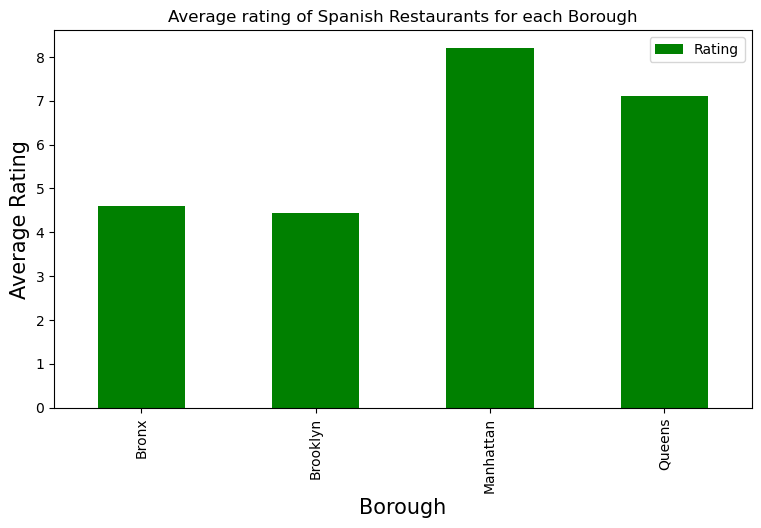

In [30]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Spanish Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
spanish_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

We will consider all the neighborhoods to visualize on map.

In [35]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=0.1]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Baychester,7.90
1,Bayside,7.90
4,Brownsville,7.00
5,Chinatown,8.60
7,Cobble Hill,9.00
11,Fordham,7.05
15,Inwood,8.30
16,Jackson Heights,7.60
17,Kingsbridge,7.50
18,Little Italy,9.10


In [36]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Bronx,Baychester,40.866858,-73.835798,7.90
1,Queens,Bayside,40.766041,-73.774274,7.90
2,Brooklyn,Brownsville,40.663950,-73.910235,7.00
3,Manhattan,Chinatown,40.715618,-73.994279,8.60
4,Brooklyn,Cobble Hill,40.687920,-73.998561,9.00
5,Bronx,Fordham,40.860997,-73.896427,7.05
6,Manhattan,Inwood,40.867684,-73.921210,8.30
7,Queens,Jackson Heights,40.751981,-73.882821,7.60
8,Bronx,Kingsbridge,40.881687,-73.902818,7.50
9,Manhattan,Little Italy,40.719324,-73.997305,9.10


In [37]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [38]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)

**RESULTS/ CONCLUSION**

Manhattan and Brooklyn have the best rated Spanish restaurants on average. Staten Island and The Bronx have the least amount of Spanish restaurants per borough. However, of note, The Bronx has the highest number of Spanish Restaurants in all of NY. Despite Manhattan having the least number of neighborhoods in all five boroughs, it has the most number of spanish restaurants. Based on the above information, I would state that Manhattan and Brooklyn are the best locations for spanish cuisine in NYC. To have the best shot of success, I would open a spanish restaurant in Brooklyn. Brooklyn has multiple neighborhoods with average ratings exceeding 8.0 on a scale of 1.0 to 10.0 and has less amount of spanish restaurants than Manhattan, making competition easier. Also we should keep in mind, that real estate prices in Brooklyn are much cheaper than in Manhattan. Finally, I would go to OOTOYA in Manhattan for the best spanish food based on 1213 likes. As a final note, all of the above analysis is depended on the accuracy of Four Square data. A more comprehensive analysis and future work would need to incorporate data from other external databases.